In [13]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pysal as ps
import mplleaflet
import shapely.geometry as geom

In this lab, we're going to review geometry processing techniques with GeoPandas (and Shapely). The objectives are:
<ol type="1">
<li>Given a set of bus location pings, we would like to know its total travel distance.</li>
<li>Providing two shapes of the M1 and M101 bus line, which shape better match our bus location pings.</li>
<li>We also want to determine which neighborhood the bus line in (2) is supposed to pass by.</li>
</ol>

In [14]:
# For objective (1), we first read in the pings

pings = pd.read_csv('bus_pings.csv')
pings.head()

,latitude,longitude,time_received
0,40.785771,-73.948824,2014-08-04 10:52:20+00
1,40.786756,-73.948217,2014-08-04 10:52:51+00
2,40.787633,-73.947470,2014-08-04 10:53:22+00
3,40.789476,-73.946423,2014-08-04 10:53:53+00
4,40.789653,-73.946303,2014-08-04 10:54:24+00


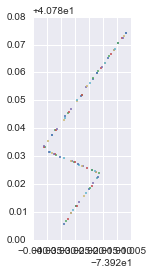

In [15]:
# We're going to use the longitude and latitude columns to 
# construct a set of points and visualize them

longlat = pings[['longitude', 'latitude']]
points = map(geom.Point, longlat.as_matrix().tolist())
gpos = gpd.GeoSeries(points)
gpos.plot()

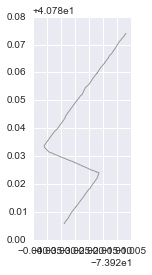

In [16]:
# In order to compute the travel distance, we need to work
# with LineString instead of just points.

path = geom.LineString(longlat.as_matrix().tolist())
gpath = gpd.GeoSeries(path)
gpath.plot()

In [17]:
# GeoPandas provides a length property to store the
# total length of a line string. We could use that
# for the first objective

gpath.length

0    0.094961
dtype: float64

In [18]:
# However, this doesn't look quite right. The problem
# is that the coordinates were in lat and long, thus,
# the unit of the length is actually in degree! We
# need to project the geometry into a planar projection
# system to get a human readable length. We're going to
# use the NAD83 New York Long Island Projection system,
# EPSG 2263.

# this is the source projection (WGS84 in longlat)
epsg4326 = {'init': 'epsg:4326'}

gpos.crs = epsg4326
projectedPos = gpos.to_crs(epsg=2263)

gpath.crs = epsg4326
projectedPath = gpath.to_crs(epsg=2263)
projectedPath.length

0    31093.149834
dtype: float64

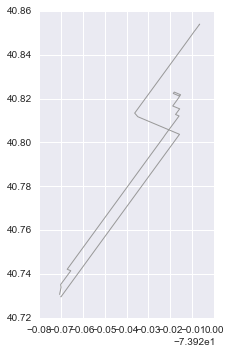

In [7]:
# For the second objective, we first read the shape of
# the M1 and M101 bus

def readShape(filename):
    data = pd.read_csv(filename)
    ptns = data[['shape_pt_lon', 'shape_pt_lat']]
    line = geom.LineString(ptns.as_matrix().tolist())
    return gpd.GeoSeries(line, crs=epsg4326)
    
m1 = readShape('m1_route.csv')
m101 = readShape('m101_route.csv')
m1.plot()
m101.plot()

In [8]:
# To find which bus line our location pings belong to,
# we compute the distance between our bus ping and the
# shapes of M1 and M101 buses.

d1 = [m1.to_crs(epsg=2263).distance(p)[0] for p in projectedPos]
d101 = [m101.to_crs(epsg=2263).distance(p)[0] for p in projectedPos]

In [9]:
# Based on the maximum distance between the pings and the shape,
# we can conclude that the pings are from the M101 bus line

max(d1), max(d101)

(11738.688472511016, 105.53850073818477)

In [11]:
# For the last objective, we can find which neighborhoods
# the M101 bus line is going through by performing an
# intersection test between the neighborhood boundaries and
# the M101 shape.

neighborhoods = gpd.read_file('neighborhood_nta_census.geojson')
intersections = neighborhoods.intersection(m101[0])
intersections

0                                                     ()
1                                                     ()
2                                                     ()
3                                                     ()
4                                                     ()
5                                                     ()
6                                                     ()
7                                                     ()
8                                                     ()
9                                                     ()
10                                                    ()
11                                                    ()
12                                                    ()
13                                                    ()
14                                                    ()
15                                                    ()
16                                                    ()
17                             

In [12]:
# We can see that there're a few neighborhoods are
# intersected. Next, we're going to list their names.

names = dict([(neighborhoods.ix[i]['ntaname'],g) 
              for i,g in enumerate(intersections)
              if type(g)!=geom.GeometryCollection])
names.keys()

[u'East Harlem North',
 u'Upper East Side-Carnegie Hill',
 u'Central Harlem South',
 u'Lenox Hill-Roosevelt Island',
 u'Gramercy',
 u'Washington Heights South',
 u'Murray Hill-Kips Bay',
 u'Manhattanville',
 u'Turtle Bay-East Midtown',
 u'Morningside Heights',
 u'East Village',
 u'Yorkville',
 u'East Harlem South',
 u'Washington Heights North',
 u'Hamilton Heights']